# Modeling a heterogeneous system

One of the main purposes of NetworkDynamics.jl is to facilitate
modeling coupled systems with heterogenities. This means that
components can differ in their parameters as well as in their dynamics.


## Heterogenous parameters
We start by setting up a simple system of Kuramoto oscillators.

In [1]:
using NetworkDynamics, OrdinaryDiffEq, Plots, LightGraphs


N = 8
g = watts_strogatz(N,2,0) # ring network

function kuramoto_edge!(e, θ_s, θ_d, K, t)
    e[1] = K * sin(θ_s[1] - θ_d[1])
end

function kuramoto_vertex!(dθ, θ, e_s, e_d, ω, t)
    dθ[1] = ω
    oriented_symmetric_edge_sum!(dθ, e_s, e_d)
end

vertex! = ODEVertex(f! = kuramoto_vertex!, dim = 1, sym=[:θ])
edge!   = StaticEdge(f! = kuramoto_edge!, dim = 1)
nd! = network_dynamics(vertex!, edge!, g);

Introducing genous parameters is as easy as defining an array.
Here the vertex parameters are genous, while the edges share the same coupling
parameter K.

In [2]:
ω = collect(1:N)./N
ω  .-= sum(ω)/N
K  = 3.
p  = (ω, K); # p[1] vertex parameters, p[2] edge parameters

Integrate and plot

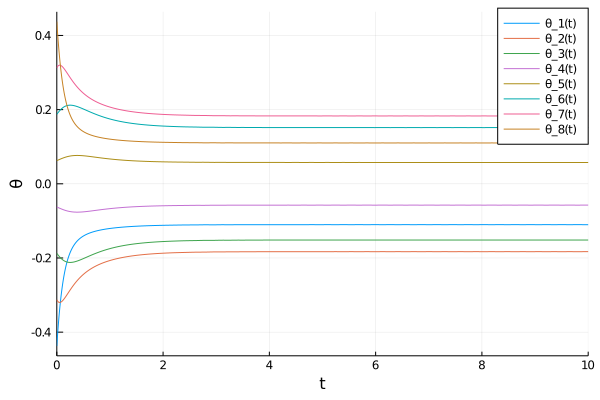

In [3]:
x0 = collect(1:N)./N
x0 .-= sum(x0)./N
tspan = (0., 10.)
prob = ODEProblem(nd!, x0, tspan, p)
sol = solve(prob, Tsit5())
plot(sol, ylabel="θ")

## Heterogenous dynamics

Two paradigmatic modifications of the node model above are static nodes and nodes with
inertia. A static node has no internal dynamics and instead fixes the variable at a
constant value. A Kuramoto model with inertia consits of two interal variables leading to
more complicated (and for many applications more realistic) local dynamics.

In [4]:
static! = StaticVertex(f! = (θ, e_s, e_d, c, t) -> θ .= c, dim = 1, sym = [:θ])


function kuramoto_inertia!(dv, v, e_s, e_d, P, t)
    dv[1] = v[2]
    dv[2] = P - 1. * v[2]
    for e in e_s
        dv[2] -= e[1]
    end
    for e in e_d
        dv[2] += e[1]
    end
end

inertia! = ODEVertex(f! = kuramoto_inertia!, dim = 2, sym= [:θ, :ω]);

Since now we model a system with genous node dynamics we can no longer
straightforwardly pass a single VertexFunction to `network_dynamics` but instead have to
hand over an Array.

In [5]:
vertex_array    = Array{VertexFunction}([vertex! for i = 1:N])
vertex_array[1] = static!
vertex_array[5] = inertia! # index should correspond to the node's index in the graph
nd_hetero!   = network_dynamics(vertex_array, edge!, g);

Now we have to take a bit more care with defining initial conditions and parameters.
For the static! node the initial condition has to match its parameter. For simplicity
we use the same parameters as above.

In [6]:
x0[1] = ω[1];

The node with inertia is two-dimensional, hence we need to specify two initial conditions.
For the first dimension we keep the ic from above and insert! another one into `x0` at
the correct index.

In [7]:
inertia_ic_2 = 5
insert!(x0, 6, inertia_ic_2);

`x0[1:4]` holds ic for nodes 1 to 4, `x0[5:6]` holds the two
initial conditions for node 5, `x0[7:9]` holds ic for nodes 6 to 8.

In [8]:
prob_hetero = ODEProblem(nd_hetero!, x0, tspan, p)
sol_hetero = solve(prob_hetero, Rodas4());

For clarity we plot only the variables refering to the oscillator's angle θ and color
them according to their type.

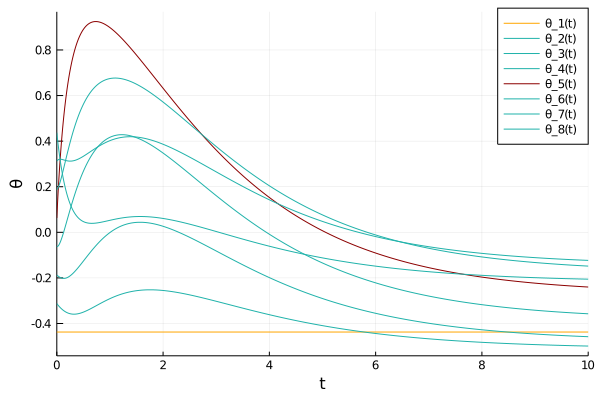

In [9]:
membership = ones(Int64, N)
membership[1] = 2
membership[5] = 3
nodecolor = [colorant"lightseagreen", colorant"orange", colorant"darkred"];
nodefillc = reshape(nodecolor[membership], 1, N);

vars = syms_containing(nd_hetero!, :θ);
plot(sol_hetero, ylabel="θ", vars=vars, lc = nodefillc)

## Components with algebraic constraints

If one of the network components contains an algebraic as well as dynamical component,
then there is the option to supply a mass matrix for the given component. In general this
will look as follows:

In [10]:
function edgeA!(de, e, v_s, v_d, p, t)
    de[1] = f(e, v_s, v_d, p, t) # dynamic variable
    e[2]  = g(e, v_s, v_d, p, t) # static varibale
end

M = zeros(2,2)
M[1,1] = 1

nd_edgeA! = ODEEdge(f! = edgeA!, dim = 2, mass_matrix = M);

This handles the second equations as `0 = M[2,2] * de[2] = g(e, v_s, v_d, p, t) - e[2]`.

See the example kuramoto_plasticity.jl and the discussion on [github](https://github.com/FHell/NetworkDynamics.jl/issues/45#issuecomment-659491913) for more details.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*